# Data Project 2: Observing Planet Formation
In this project, we will put together what we've learned about radiation and disk structure to construct a synthetic observation, that of a *spectral energy distribution*. You will use and adapt a code to fit to set of photometric data points from an existing protoplanetary disk observation (provided) in order to infer the properties of the disk. 
This assignment has been scaffolded: there is existing code provided as an example and some functions have been pre-defined for your use with comments marking areas in which you should add your own inputs. Regions for your input will have a ```# * HERE * #``` comment.  You may need to write additional code. 

> Instructions for the code and required questions will appear like this.

You can choose to modify the existing code to do more as long as the main brief is fullfilled and the final result can be run only from what is contained in your submitted notebook. 

Cells that have text in them (markdown cells) can be double-clicked to edit. Be sure to answer the questions in the markdown cells by editing in your own answer.

*NOTE:*
Feel free to work collaboratively with other members of the class on the coding portions of this project. However, the **Questions** must be answered in your own words and reflect your own thinking.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

In [2]:
# define some constants 
kb = 1.3807e-16 #Boltzmann constant cgs
Gconv = 6.6743e-8 # cgs
sigsb = 5.671e-5 #Stefan Boltzmann constant
c = 2.99792458e10 # speed of light cgs
h = 6.6260755e-27 #planck constant cgs
mh = 1.67e-24 # mass of hydrogen cgs
pc = 3.086e18 #parsecs in cm
au = 1.49598e13 #au in cm
Rsun = 69.6e9 # solar radius in cm

In `2-sed.csv`, is data for a set of photometric observations for Mystery Disk object.   
The columns correspond to:

`lam_obs`: $\lambda$ wavelength in microns  
`sed_obs`: $\lambda F_\lambda$ the flux density multiplied by the photometric bandpass in ergs per cm squared per s (normalized to a distance of 1 pc away)  

> Run the cell below to load in the data and show a plot of the SED

Later on, you can use `plot_SED(lam_obs, sed_obs)` as a convenience function to plot the observed points.

As you work through the notebook, you'll build a simple model for these observations.

Text(0.5, 1.0, 'Observed SED of Mystery Disk')

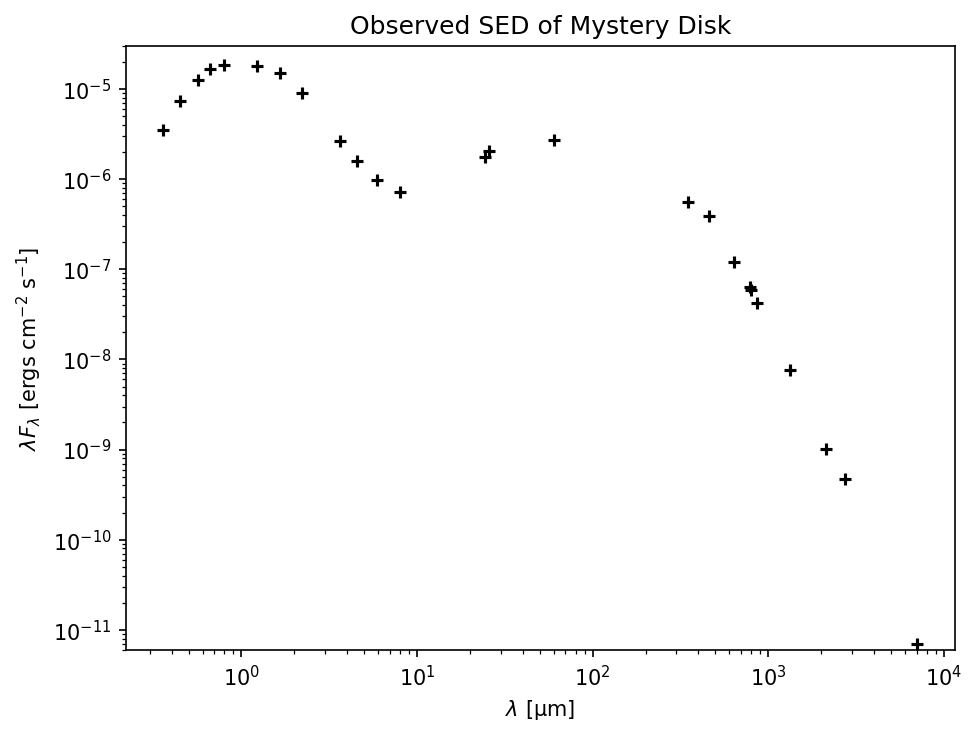

In [3]:
lam_obs, sed_obs = np.loadtxt('2-sed.csv', unpack=True,delimiter=',')

def plot_SED(lam,sed):
    """ Function to plot observed SED points"""
    f,ax = plt.subplots(1,constrained_layout=True,dpi=150)
    d_conv = 140 ** 2
    ax.scatter(lam, sed * d_conv, marker='+',color='black',label='SED')
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$\lambda \ \mathrm{[\mu m]}$')
    ax.set_ylabel(r'$\lambda F_\lambda \ \mathrm{[ergs \ cm^{-2} \ s^{-1} ]}$')
    ax.set_ylim(6e-12,3e-5)
   

plot_SED(lam_obs, sed_obs)
ax = plt.gca()
ax.set_title('Observed SED of Mystery Disk')

## Part I: Building a Blackbody Spectrum

Looking at the SED, you can see that there are two main sources: one narrow peak in the optical and a broader peak at longer wavelengths, this is the emission from the protostar and the disk, respectively. 

That means we want to build a two-component model for the emission intensity:

$I_{\lambda} = I_{star,\lambda} + I_{disk,\lambda}$

We'll start by using a basic blackbody to model the emission from the protostar:

$I_{star,\lambda} = B_\lambda(T_s)$

In the cell below:

> Define a function to calculate where the peak wavelength of a $T_s = 4350 \  \mathrm{K}$ should be. 
> Denote it's location on the plot with a vertical line.

> Use the functions defined below to calculate and plot $\lambda F_\lambda$ of a model protostar with:  
> $T_s = 4350 \  \mathrm{K}$  
> $R_s = 1.7 \  \mathrm{R_{\odot}}$  
> at a reference distance of 1 pc to match that of the source observation

Compare to the observations:
> Plot the observed SED on the same plot


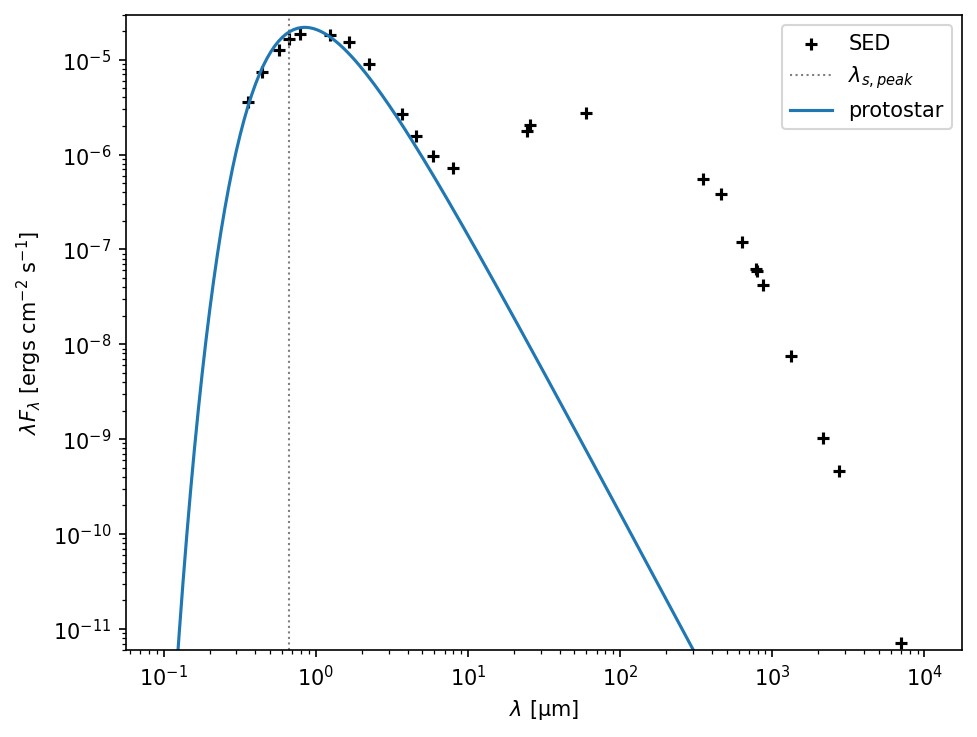

In [18]:

def lam_peak(T):
    """Given an input temperature in K returns the location of the peak wavelength in microns"""
    return 2897/T

def BB_lam(lam, T):
    """ planck function for a blackbody in terms of wavelength and temperature
    lam: input wavelengths in microns
    T: input temperature in K 
    returns black body intensity in ergs/cm^2/s/mu m/str"""
    lam_cgs = lam * 1e-4 # microns to cm
    prefactor = 2. * h * c**2 / (lam_cgs**5)
    exponent = np.clip(h * c / (lam_cgs * kb * T),-600,600) # to avoid overflow issues in exponential function
    B_lam =  prefactor / (np.exp(exponent) - 1.) # ergs/cm^2/s/cm/ str 
    return B_lam * lam_cgs / lam # now in  ergs/cm^2/s/ mu m/ str

def F_star(lam,Tstar=4000, Rstar = 2. * Rsun, d= 1  * pc):
    """ calculate the flux density coming from a star with radius Rstar at reference distance d"""
    area_star = np.pi * Rstar**2 
    return BB_lam(lam,Tstar) * area_star / d / d # now in ergs/cm^2/mu m at d pc


#plot SED
plot_SED(lam_obs,sed_obs)
ax = plt.gca() # get axis of plot

# Define the wavelengths the models will be computed over
lam_mu = np.logspace(-1,4,200) # in MICRONS

# Plot location of peak wavelength
T_s = 4350
R_s = 1.7 * Rsun
ax.axvline(lam_peak(T_s), ls='dotted',lw=1,color='gray',label=r'$\lambda_{s,peak}$')

# Plot protostar lambda Flambda
ax.plot(lam_mu, lam_mu * F_star(lam_mu, T_s, R_s, 1*pc),label='protostar')
ax.legend()
 

### Questions

> 1. On the plot, if you have plotted the model correctly, you will notice that the highest point of the protostar model curve appears to be at **slightly** longer wavelengths than the location of $\lambda_{peak}$. Briefly explain why.

*your answer here*


## Part II. Building a Disk Model
Now we want to build a more complicated model for the disk emission. You'll notice that the emission in the infrared is quite broad -- too broad to be fit by a single blackbody. 

By the end of this part, We are going to model the disk as a series of concentric annular slabs of radius $r_a$, each emitting as modified blackbodies of temperature $T_a$. 

$I_{disk,\lambda} = \sum I_{\lambda}(r_a, T_a)$

### a. Basic Slab Model
First, we'll build what's called a *slab model* to represent the emission from one annulus, which we take to be coming from a specific radial location in the disk.
We'll assume each slab has some optical depth $\tau_a$ and a single temperature $T_a$ throughout. 

Recall that the solution to the equation of radiative transport for a constant source function:
$I_{\lambda}(r_a,T_a) = S_\lambda(T_a) (1 - e^{-\tau_a})$

Here we are modeling the thermal emission of the dust, so $S_\lambda = B_\lambda$.

In the cell below:

> Define a function to calculate the model intensities of a slab at temperature $T_a$ and optical depth $\tau_\lambda$

> Define a function to calculate the corresponding flux of this annular slab at some separation $r_a$ and radial width $dr_a$ from the star at a reference distance of 1 pc

> Plot $\lambda F_\lambda$ for slabs with:    
> slab 1: r_a = 1 au, dr_a = 1_au, T_a = 288 K, tau_a = 2/3  
> slab 2: r_a = 100 au, dr_a = 1_au, T_a = 28 K, tau_a = 2/3  

> Plot the emission for slab 1 + slab 2 = emission from two narrow optically thick rings, at 1 au and 100 au. 


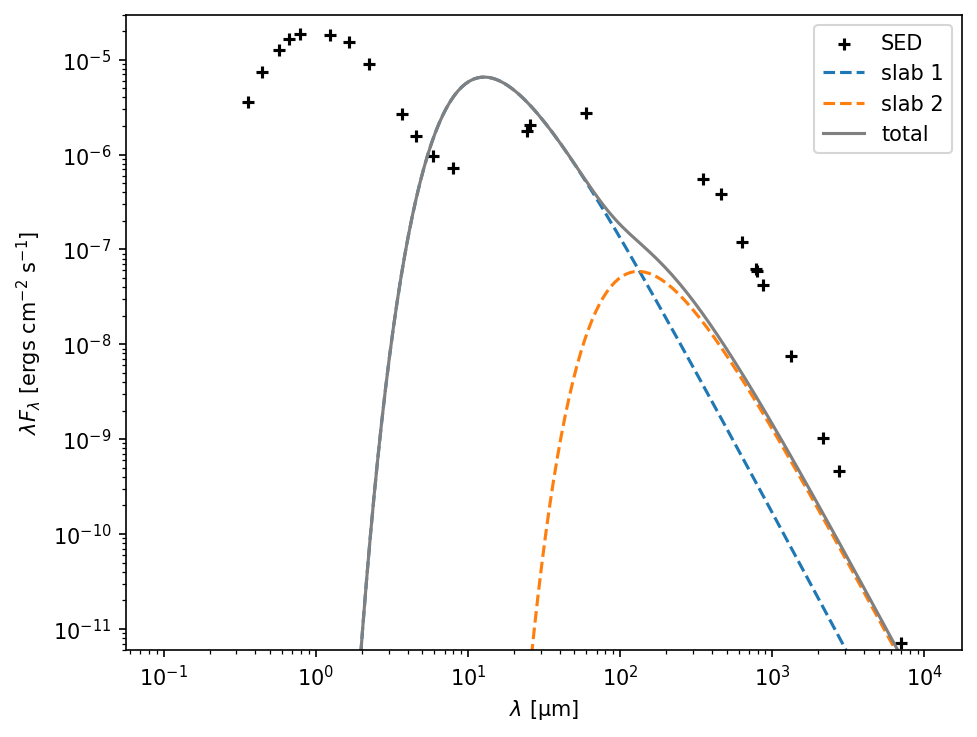

In [21]:
lam_model = np.logspace(-1,4,100) #logarithmically spaced array from 1 micron to 1 cm in microns.

def I_a(lam, T_a, tau_a):
    """ returns the intensity as a function of wavelength lam given some slab T_a, tau_a"""
    i = BB_lam(lam, T_a) * (1 - np.exp(-tau_a))
    return i

def F_a(lam, T_a, tau_a, r_a, dr_a,d = 1 * pc):
    """ calculate the flux from an annulus of temperature T_a, optical depth tau_a, distance r_a away from the star, of width dr_a and observed at reference distance d """
    I_slab = I_a(lam, T_a, tau_a)
    def calc_area(r,dr):
        """ calculate the area of your annular slab of disk given it's location r and radial width dr
        r: in au
        dr: in au """
        return 2 * np.pi * r * au * dr * au
    area_slab = calc_area(r_a,dr_a)
    return I_slab * area_slab/ d / d

plot_SED(lam_obs,sed_obs)
ax = plt.gca() # get axis of plot

# Define the wavelengths the models will be computed over
lam_mu = np.logspace(-1,4,200) # in MICRONS

# Plot slab
slab_1 = F_a(lam_mu, 288, 2/3, 1, 1)
slab_2 = F_a(lam_mu, 28, 2/3, 100, 1)
slab_tot = slab_1 + slab_2
ax.plot(lam_mu, lam_mu * slab_1,label='slab 1',ls='dashed')
ax.plot(lam_mu, lam_mu * slab_2, label='slab 2',ls='dashed')
ax.plot(lam_mu, lam_mu * (slab_1 + slab_2), label='total',color='gray')
ax.legend()

### Questions

> 1. Based on the plots of your two slabs, which parts of a disk SED (i.e. which wavelength ranges) do you expect to represent inner disk emission vs. what parts see contributions from outer disk emission?

*your answer here*

> 2. If you plot to compare to the observed SED, you'll notice that one of the slabs considerably overestimates the emission at it's peak wavelength compared to the measured value. What might that be telling you about the structure of this particular Mystery Disk?

*your answer here*

### Part b. Build a Disk from Slabs
Now that we have the machinery to put together some slabs, let's construct a disk model and plot what it's emission should look like. For each annular slab, we'll want it's radial location $r_a$, it's temperature $T_a$ and it's optical depth $\tau_a$. 

Let's adopt the simplest model for a protoplanetary disk assuming an axisymmetric disk described by radial power-law profiles in:
1. Temperature: $T = T_0 (r/r_0)^{-q}$
2. Dust Surface Density: $\Sigma_d = \Sigma_0 (r/r_0)^{-p}$

We'll assume a very simple power-law opacity model for the dust:
$\kappa_d = \kappa_0 \left (\frac{\lambda}{\lambda_0} \right )^{- \beta}$


$\kappa(\lambda_0 = 1\  \mu m) = 120 \ \mathrm{cm^2 \ g^{-1}}$  
$\beta = 1$  


Note: If you're wondering why opacity here is denoted $\kappa$, recall that $\alpha_\nu = \kappa_\nu + \sigma_\nu$, but we are neglecting scattering so $\alpha_\nu = \kappa_\nu$.
In the cell below, for a range of radii:
> Define a function to calculate the optical depth $\tau_a$ given the opacity law and surface density. 


> Compute a model temperature profile `T_model` assuming irradiation from a central star matching the parameters we adopted for our protostar.

> Compute a model dust surface density `sig_model` given some radius r_a assuming a minimum mass solar nebula profile for the gas:  
> $\Sigma_g = 1700 \mathrm{g \ cm^{-2}} \left ( \frac{r}{\rm 1 au} \right )^{-1} $ 
> With an ISM-like dust-to-gas ratio  
> $\Sigma_d = 0.01 * \Sigma_g$  



> Plot the radial profiles of surface density and temperature for the disk model.



In [6]:
def Sigma_d(r_a,Sigma0,r0,p):
    """returns the surface density for each point r_a according to a power-law profile"""
    return Sigma0 * (r_a/r0)**(-p)

def T_d(r_a,T0,r0,q):
    """returns the temperature for each point r_a according to a power-law profile"""
    return T0 * (r_a/r0)**(-q)

def tau_lam(lam, sig_a):
    """returns the optical depth for wavelengths lam with surface density sig_a"""
    def kappa_lam(lam,kappa_0 = 120, lam_0 = 1, beta = 1):
        """ returns an opacity in units of cm^2/g as a function of wavelength given some power-law """
        return kappa_0*(lam/lam_0)**(-beta)
    # your function * HERE *
    return 

# construct the range of radii you will make annular slabs over
r_min = 1   # au # minimum radius to consider
r_max = 200 # au # maximum radius to consider

dr_a = 1 # au # radial width of annuli
r_model = np.arange(r_min,r_max+1,dr_a) # list of locations of annuli you are making 

#sig_model = 
#T_model = 

def plot_diskmodel(r_model,sig_model,T_model):
    f,(a1,a2) = plt.subplots(1,2, constrained_layout=True,sharex=True,dpi=150)
    f.set_size_inches((6.5,3))
    a1.plot(r_model,sig_model,lw=1,marker='.')
    a1.set_ylabel(r'$\Sigma_{dust} \ \mathrm{[g \ cm^{-2}]}$')

    a2.plot(r_model,T_model,lw=1, marker='.')
    a2.set_ylabel('T [K]')

    for a in [a1,a2]:
        a.set_xscale('log')
        a.set_xlabel('r [au]')

    f.suptitle('Disk Model')

#plot_diskmodel(r_model,sig_model,T_model)

Now we'll plot it all together!

Use the code below to sum up the emission from all of the annuli to get the total disk flux. 

> Plot the protostar model

> Plot the disk model

> Plot the total SED (disk + star) model

And compare to the observed SED. 

In [ ]:
# Sum up the annuli
#F_disk = np.zeros_like(lam_mu)
#for r_a, sig_a, T_a in zip(r_model,sig_model,T_model):
#    tau_a = tau_lam(lam_mu, sig_a)
#    F_disk += F_a(lam_mu, T_a, tau_a, r_a, dr_a=1,d = 1 * pc)

plot_SED(lam_obs,sed_obs)
ax = plt.gca() # get axis of plot

# Define the wavelengths the models will be computed over
lam_mu = np.logspace(-1,4,200) # in MICRONS

# plot all the model components + total SED flux
#F_s = F_star(lam_mu,Tstar=T_s,Rstar=R_s)
#ax.plot(lam_mu, ...,label='disk',ls='dashed')
#ax.plot(lam_mu, ...,label='protostar',ls='dashed')
#ax.plot(lam_mu, ...,label='SED model',color='gray',lw=1.5)
#ax.set_title('Initial Disk Model')
#ax.legend()

### 

### Questions

> 1. The toy disk model we prescribed doesn't seem to fit very well. (This shouldn't be that surprising, we can't really expect an entirely arbitrary model to fit our random Mystery system!) For which range of wavelengths is there the biggest departure? What radii in the disk does this correspond to?

*your answers here*

> 2. Come up with a single change within the overall model (i.e. altering a single parameter like `r_min`, `r_max`, `p`, `q`, `Sigma0`,`kappa0` etc.) that you think would make the model more like the observations. Write a few sentences to justify this change, that is: address how you think that would affect the model SED and explain why it alters the emission.

*your answers here*



### Part c: Refine the Model

> Make the change you describe in Question 2 in the cell below. 

> Plot the new disk model in comparison to the observations.

In [ ]:
#r_min = 10  # au # minimum radius to consider
#r_max = 200 # au # maximum radius to consider

#dr_a = 1 # au # radial width of annulus
#r_model = np.arange(r_min,r_max+1,dr_a) # radial location of each annulus

#sig_model = 
#T_model = 

# Sum up the annuli
#F_disk = np.zeros_like(lam_mu)
#for r_a, sig_a, T_a in zip(r_model,sig_model,T_model):
#    tau_a = tau_lam(lam_mu, sig_a)
#    F_disk += F_a(lam_mu, T_a, tau_a, r_a, dr_a=1,d = 1 * pc)

plot_SED(lam_obs,sed_obs)
ax = plt.gca() # get axis of plot

# Define the wavelengths the models will be computed over
lam_mu = np.logspace(-1,4,200) # in MICRONS

#F_s = F_star(lam_mu,Tstar=T_s,Rstar=R_s)
#ax.plot(lam_mu, ,label='disk',ls='dashed')
#ax.plot(lam_mu,  ,label='protostar',ls='dashed')
#ax.plot(lam_mu,  ,label='SED model',color='gray',lw=1.5)
#ax.set_title('Refined Disk Model')
#ax.legend()

### Questions

> 1. Even though we made a fairly simple model to make the model SED emission, there were still a lot of parts that went into getting out an SED. Many times in science we have to make choices about making and fitting models in terms of which parts of them we should "freeze" and which things we should vary. Generally, it's a better choice to freeze aspects of the model that we are more confident about, have a measurement or previous constraint on, or are set by the physics rather than just a choice of parameter. 
> Of the three main aspects of the model:  
> a. Temperature profile  
> b. Surface density profile  
> c. Dust Opacity   
> Which do you think would be best to freeze and which do you think would be best to vary? Explain your reasoning.

*your answers here*

> 2. The other tricky thing about model fitting is *degeneracy*: when two aspects or parameters of the model contribute to changing the same part of the model. i.e. raising one parameter's value affects the value of the model at some range of wavelengths in the same way as raising or lowering a different parameter's value. What is one potential source of degeneracy you can identify in this model?

*your answers here*


> 3. (Very Optional Bonus) This Mystery Object is a real bona fide disk observation that has been actually fit in the literature with multiple components: (each having it's own range of radii, temperatures, and opacities) with a different model for the inner disk vs. the outer disk. Create a two component model of your own for these observations that does a better job of representing the features in the data. How is the inner disk different from the outer disk?

*your answers here*



# Project Rubric
Learning Objectives:
+ Use an observational dataset to make comparisons to a model.
+ Construct a model for the physical properties of a disk.
+ Apply radiative transfer concepts to construct a synthetic observation based on a physical disk model.
+ Use plots to reason about observed data and apply physical principles to the interpretation of the results.
+ Evaluate a model on its parameters and constraints.

Projects will be in the range for the following letter grades according to the criteria below: 

**A**: all parts (including responses to the required questions) are fully completed, most major objectives fully achieved and demonstrated

**B**: all parts (including responses to the required questions) are mostly completed, most major objectives at least partially acheived and demonstrated

**C**: part I, part II a and b (including responses to the required questions) are completed w/ major objectives partially achieved and demonstrated. part II c has been attempted so far as to demonstrate some of the major objectives

## Submission format
Your submitted notebook should include all the code and answers to questions that you plan on submitting.

All code to generate your results should be present and run independently from start to finish (i.e. if you click restart kernel, you should be able run each cell in order of appearance and reproduce the cell outputs) 

Prior to submission, save the file with all cells executed and all plots generated.